In [183]:
#Import modules
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pickle
import joblib
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
from io import BytesIO

In [184]:
# Define IAM role
role = get_execution_role()
print(role)
prefix = 'n2oriskdss/mdt'
my_region = boto3.session.Session().region_name # set the region of the instance

arn:aws:iam::956662347865:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


In [186]:
#get the dataset to train the model
path_dataset = 's3://n2oriskdss/mdt/DEMO_prepared.csv' # <<< MODIFY HERE
df_read = pd.read_csv(path_dataset)
df_read.head()

,time,DO,NH4,NO3,N2O
0,2018-06-08T00:00:00.000Z,0.308,6.984,2.462,0.48
1,2018-06-08T00:15:00.000Z,0.298,7.565,2.623,0.45
2,2018-06-08T00:30:00.000Z,0.210,7.487,2.615,0.46
3,2018-06-08T00:45:00.000Z,0.205,7.902,2.762,0.51
4,2018-06-08T01:00:00.000Z,0.347,7.829,2.762,0.47


In [187]:
#THIS CODE CAN BE USED TO DROP THE PREDICTION COLUMN
#df_read.drop('prediction', inplace=True, axis=1)
#df_read.head()

In [191]:
#We separate the train dataset and the test dataset in a ratio 80 % - 20 %
train_data, test_data = np.split(df_read.sample(frac=1, random_state=1729), [int(0.8 * len(df_read))])

In [192]:
#We define the Random Forest Model
clf = RandomForestRegressor(n_estimators=100, random_state=1337, max_depth=12, min_samples_leaf=2, verbose=2)

In [193]:
#We define the features
data_list = ['NH4', 'NO3', 'DO'] # <<< MODIFY HERE

In [194]:
#We setup the features and the target
X_train = train_data.loc[:, data_list]
X_test = test_data.loc[:, data_list]
y_train = np.array(train_data['N2O'])
y_test = np.array(test_data['N2O'])

In [195]:
#We train the model, get prediction on the test and get r2 score from the test
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
r2 = r2_score(y_test.tolist(), predictions.tolist())

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [197]:
#We get information from the modeling
print('the r2 score is', r2)
print(X_train.columns[0], 'importance is',clf.feature_importances_[0]*100, '%')
print(X_train.columns[1], 'importance is',clf.feature_importances_[1]*100, '%')
print(X_train.columns[2], 'importance is',clf.feature_importances_[2]*100, '%')

the r2 score is 0.7473146868032282
NH4 importance is 29.12760924824682 %
NO3 importance is 24.28282835799338 %
DO importance is 46.5895623937598 %


In [198]:
#We apply the model to the full dataset
X = df_read.loc[:, data_list]
predictions = clf.predict(X)
df_read['prediction'] = predictions

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


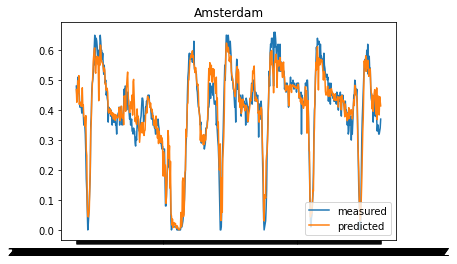

In [203]:
#We plot the result
plt.plot(df_read['time'], df_read['N2O'], df_read['time'], df_read['prediction'])
plt.title('Amsterdam')
plt.legend(["measured", "predicted"], loc="lower right")
plt.show()

In [182]:
#We save the model into the s3 bucket
path = 's3://n2oriskdss/mdt/AMS_[NH4-NO3-DO].sav'
s3_bucket, s3_key = path.split('/')[2], path.split('/')[3:]
s3_key = '/'.join(s3_key)
with BytesIO() as f:
    joblib.dump(clf, f)
    f.seek(0)
    boto3.client("s3").upload_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)

In [153]:
#THIS CODE CAN BE USED TO SAVE A CSV FILE IN A S3 BUCKET
#df_read.to_csv('s3://n2oriskdss/mdt/test.csv', index=False)

In [152]:
#THIS CODE CAN BE USED TO LOAD A MODEL FROM A S3 BUCKET
#filename = 's3://n2oriskdss/mdt/AMS_[NH4-NO3-DO].sav'
#s3_bucket, s3_key = filename.split('/')[2], filename.split('/')[3:]
#s3_key = '/'.join(s3_key)
#with BytesIO() as f:
#    boto3.client("s3").download_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)
#    f.seek(0)
#    loaded_model = joblib.load(f)